In [3]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('stroke')\
    .config("spark.sql.debug.maxToStringFields", "100")\
    .getOrCreate()

from pyspark.sql.functions import col, count, mean, stddev, abs, udf, isnan, when
from pyspark.sql.types import FloatType, DoubleType, IntegerType, LongType, ShortType, StringType

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, QuantileDiscretizer, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors

# 防止一些内建函数，例如round和abs 与spark.sql中的round和abs 搞混
import builtins  

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 08:35:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data Understanding

## Data Import

In [4]:
# import data with header and auto-datatype
data = spark.read.csv('brain_stroke.csv', header=True, inferSchema=True)


In [5]:
# data glance
data.show(5)

data.columns

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [6]:
data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



## Data Cleaning

In [7]:
from pyspark.sql.functions import col, count, mean, stddev, abs, round
from pyspark.sql.types import FloatType, DoubleType, IntegerType, LongType, ShortType, StringType

# 总行数
total_rows = data.count()

# 计算每列的非空（non-null）值的比例
complete_rates = {column: (data.filter(col(column).isNotNull()).count() / total_rows) * 100 
                  for column in data.columns}

# 输出
print("Complete Rates:")
for column, rate in complete_rates.items():
    print(f"{column}: {rate:.2f}%")

# 计算每列的均值和标准差
from itertools import chain

# 计算每列的均值和标准差
mean_stddev = data.select(*chain(*[(mean(col(column)).alias(f"{column}_mean"), 
                                   stddev(col(column)).alias(f"{column}_stddev")) 
                                  for column in data.columns if data.schema[column].dataType in 
                                  [FloatType(), DoubleType(), IntegerType(), LongType(), ShortType()]]))


# 将结果从 Row 转换为字典以便使用
mean_stddev_values = {**mean_stddev.first().asDict()}

# 计算 Z 分数
# Z = (X-mean)/std
for column in data.columns:
    if data.schema[column].dataType in [FloatType(), DoubleType(), IntegerType(), LongType(), ShortType()]:
        data = data.withColumn(f"{column}_zscore", 
                           (col(column) - mean_stddev_values[f"{column}_mean"]) / 
                           mean_stddev_values[f"{column}_stddev"])

# 指定的阈值,设置为3.2*std
threshold = 3.2

# 计算每个列的离群值的比例
outlier_percentages = {column: (data.filter(col(f"{column}_zscore").isNotNull() & 
                                       (abs(col(f"{column}_zscore")) > threshold)).count() / total_rows) * 100 
                       for column in data.columns if f"{column}_zscore" in data.columns}

# 输出
print("\nOutlier Percentages:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")

data.printSchema()
data.toPandas()

Complete Rates:
gender: 100.00%
age: 100.00%
hypertension: 100.00%
heart_disease: 100.00%
ever_married: 100.00%
work_type: 100.00%
Residence_type: 100.00%
avg_glucose_level: 100.00%
bmi: 100.00%
smoking_status: 100.00%
stroke: 100.00%

Outlier Percentages:
age: 0.00%
hypertension: 0.00%
heart_disease: 5.52%
avg_glucose_level: 0.50%
bmi: 0.00%
stroke: 4.98%
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- age_zscore: double (nullable = true)
 |-- hypertension_zscore: double (nullable = true)
 |-- heart_disease_zscore: double (nullable = true)
 |-- avg_glucose_level_zsco

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_zscore,hypertension_zscore,heart_disease_zscore,avg_glucose_level_zscore,bmi_zscore,stroke_zscore
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1.040480,-0.326153,4.136338,2.723138,1.193118,4.368163
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1.614108,-0.326153,4.136338,-0.000523,0.589330,4.368163
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0.246225,-0.326153,-0.241711,1.448384,0.869135,4.368163
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1.569983,3.065430,-0.241711,1.512499,-0.662425,4.368163
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,1.658234,-0.326153,-0.241711,1.780716,0.073902,4.368163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0,-0.106777,-0.326153,-0.241711,-0.794082,0.191714,-0.228883
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0,-0.150902,-0.326153,-0.241711,1.890310,0.383159,-0.228883
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0,0.069724,3.065430,-0.241711,-0.242340,0.486245,-0.228883
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0,-0.150902,-0.326153,-0.241711,-0.488150,0.221167,-0.228883


In [8]:
count_all = data.groupBy(data.columns)\
    .count()\
    .where("count > 1")

print(count_all)
# no duplicates

# 与原始数据集合并，只保留重复的行
duplicates = data.join(count_all, on=data.columns, how="inner")

# 显示重复行
duplicates.show(5)

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, Residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: int, age_zscore: double, hypertension_zscore: double, heart_disease_zscore: double, avg_glucose_level_zscore: double, bmi_zscore: double, stroke_zscore: double, count: bigint]
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+----------+-------------------+--------------------+------------------------+----------+-------------+-----+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|age_zscore|hypertension_zscore|heart_disease_zscore|avg_glucose_level_zscore|bmi_zscore|stroke_zscore|count|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+----------+-----------------

In [9]:
from pyspark.sql.functions import when, col, udf

# 将 gender 和 ever_married 列映射到整数
data = data.withColumn("gender", when(col("gender") == "Male", 1).otherwise(0))
data = data.withColumn("ever_married", when(col("ever_married") == "Yes", 1).otherwise(0))

# 定义用于创建新特征的 UDFs
# underweight - 1
# normal weight - 2
# overweight - 3
# obese - 4
def map_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 23.9:
        return 'normal weight'
    elif bmi < 27.9:
        return 'overweight'
    else:
        return 'obese'

def map_avg_glucose_level(avg_glucose_level):
    if avg_glucose_level < 70:
        return 'low blood sugar'
    elif avg_glucose_level < 100:
        return 'normal'
    else:
        return 'diabetes'

udf_map_bmi = udf(map_bmi, StringType())
udf_map_avg_glucose_level = udf(map_avg_glucose_level, StringType())

# 应用 UDFs 创建新列
data = data.withColumn("bmi_", udf_map_bmi("bmi"))
data = data.withColumn("avg_glucose_level_", udf_map_avg_glucose_level("avg_glucose_level"))

# 将年龄分箱
data = data.withColumn("age_", when(col("age") <= 20, "0-20")\
    .when((col("age") > 20) & (col("age") <= 40), "21-40")\
    .when((col("age") > 40) & (col("age") <= 60), "41-60")\
    .when((col("age") > 60) & (col("age") <= 80), "61-80")\
    .otherwise("80+"))

# 描述性统计和数据信息
data.printSchema()


root
 |-- gender: integer (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: integer (nullable = false)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- age_zscore: double (nullable = true)
 |-- hypertension_zscore: double (nullable = true)
 |-- heart_disease_zscore: double (nullable = true)
 |-- avg_glucose_level_zscore: double (nullable = true)
 |-- bmi_zscore: double (nullable = true)
 |-- stroke_zscore: double (nullable = true)
 |-- bmi_: string (nullable = true)
 |-- avg_glucose_level_: string (nullable = true)
 |-- age_: string (nullable = false)



In [10]:
data.limit(10).toPandas()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_zscore,hypertension_zscore,heart_disease_zscore,avg_glucose_level_zscore,bmi_zscore,stroke_zscore,bmi_,avg_glucose_level_,age_
0,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1,1.040480,-0.326153,4.136338,2.723138,1.193118,4.368163,obese,diabetes,61-80
1,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1,1.614108,-0.326153,4.136338,-0.000523,0.589330,4.368163,obese,diabetes,61-80
2,0,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1,0.246225,-0.326153,-0.241711,1.448384,0.869135,4.368163,obese,diabetes,41-60
3,0,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1,1.569983,3.065430,-0.241711,1.512499,-0.662425,4.368163,overweight,diabetes,61-80
4,1,81.0,0,0,1,Private,Urban,186.21,29.0,formerly smoked,1,1.658234,-0.326153,-0.241711,1.780716,0.073902,4.368163,obese,diabetes,80+
5,1,74.0,1,1,1,Private,Rural,70.09,27.4,never smoked,1,1.349357,3.065430,4.136338,-0.795414,-0.161723,4.368163,overweight,normal,61-80
6,0,69.0,0,0,0,Private,Urban,94.39,22.8,never smoked,1,1.128730,-0.326153,-0.241711,-0.256316,-0.839143,4.368163,normal weight,normal,61-80
7,0,78.0,0,0,1,Private,Urban,58.57,24.2,Unknown,1,1.525858,-0.326153,-0.241711,-1.050985,-0.632972,4.368163,overweight,low blood sugar,61-80
8,0,81.0,1,0,1,Private,Rural,80.43,29.7,never smoked,1,1.658234,3.065430,-0.241711,-0.566020,0.176987,4.368163,obese,normal,80+
9,0,61.0,0,1,1,Govt_job,Rural,120.46,36.8,smokes,1,0.775728,-0.326153,4.136338,0.322048,1.222571,4.368163,obese,diabetes,61-80


In [11]:
# 列表推导式来找到所有带有 "_zscore" 后缀的列
columns_to_drop = [col_name for col_name in data.columns if "_zscore" in col_name]

# 使用 drop 函数删除它们
data = data.drop(*columns_to_drop)

# 打印更新后的模式以确认更改
data.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: integer (nullable = false)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- bmi_: string (nullable = true)
 |-- avg_glucose_level_: string (nullable = true)
 |-- age_: string (nullable = false)



In [12]:
data.describe().toPandas()

,summary,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_,avg_glucose_level_,age_
0,count,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981
1,mean,0.41638225255972694,43.4198594659707,0.09616542862878939,0.055209797229471995,0.6585023087733387,None,None,105.94356153382824,28.498173057619002,None,0.049789198956032926,None,None,None
2,stddev,0.493007980781938,22.66275507369848,0.29484757470019735,0.2284122364309422,0.47425960627198244,None,None,45.075372808429975,6.790463626292752,None,0.21753099703366993,None,None,None
3,min,0,0.08,0,0,0,Govt_job,Rural,55.12,14.0,Unknown,0,normal weight,diabetes,0-20
4,max,1,82.0,1,1,1,children,Urban,271.74,48.9,smokes,1,underweight,normal,80+


It can be observed that the minimum value in the "age" column is 0.08, which is a floating-point value. It is likely that this value is due to data entry errors. As a result, it's reasonable to consider removing this entry to maintain the integrity and accuracy of the dataset.

In [13]:
filtered_count = data.filter((col("age") % 1) != 0).count()
total_count = data.count()

rate = filtered_count / total_count

print(f"Rate: {rate*100:.2f}%")

# small rate, we can delete

Rate: 2.19%


In [14]:
# 过滤数据，保留 'age' 列的小数部分等于 '.0' 的行
data = data.filter((col("age") % 1) == 0)

# 使用 describe 方法获取汇总统计信息并显示
data.describe().toPandas()

,summary,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_,avg_glucose_level_,age_
0,count,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872,4872
1,mean,0.41420361247947457,44.36576354679803,0.09831691297208539,0.056444991789819376,0.6732348111658456,None,None,106.1971654351392,28.716625615763586,None,0.05069786535303777,None,None,None
2,stddev,0.4926345429007665,22.00435843316842,0.2977732313141769,0.2308027048733233,0.4690787389656725,None,None,45.3450883736369,6.693728827025826,None,0.2194025347055697,None,None,None
3,min,0,1.0,0,0,0,Govt_job,Rural,55.12,14.0,Unknown,0,normal weight,diabetes,0-20
4,max,1,82.0,1,1,1,children,Urban,271.74,48.9,smokes,1,underweight,normal,80+


# Stroke Data Set EDA

In [15]:
data_zf = data.filter(col("stroke") == 1)
data_zf.toPandas()
# The subsequent data analysis and visualizations will be focused solely on exploring data related to individuals who have experienced strokes.

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_,avg_glucose_level_,age_
0,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1,obese,diabetes,61-80
1,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1,obese,diabetes,61-80
2,0,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1,obese,diabetes,41-60
3,0,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1,overweight,diabetes,61-80
4,1,81.0,0,0,1,Private,Urban,186.21,29.0,formerly smoked,1,obese,diabetes,80+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,1,79.0,0,0,1,Private,Rural,114.77,27.2,formerly smoked,1,overweight,diabetes,61-80
243,1,74.0,0,0,1,Private,Urban,167.13,28.7,Unknown,1,obese,diabetes,61-80
244,0,76.0,1,1,1,Self-employed,Urban,199.86,31.7,smokes,1,obese,diabetes,61-80
245,1,74.0,0,0,1,Self-employed,Rural,60.98,28.1,never smoked,1,obese,low blood sugar,61-80


## Categorical Bar Plot

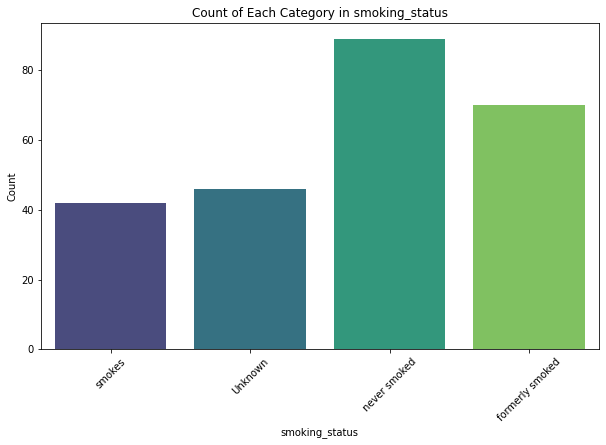

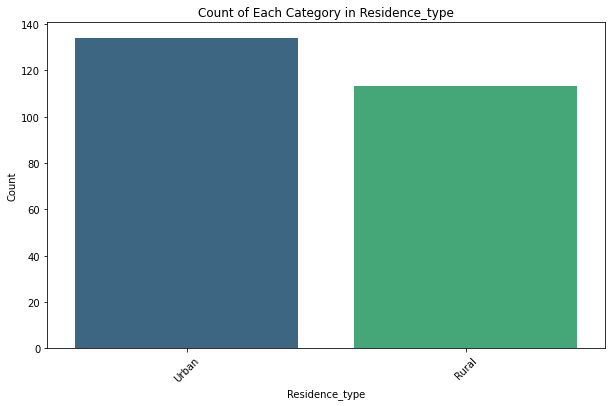

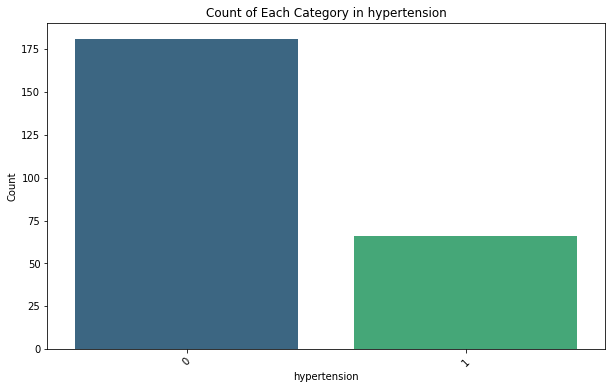

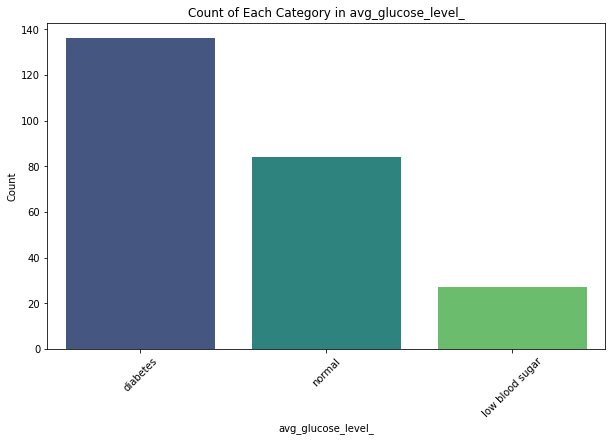

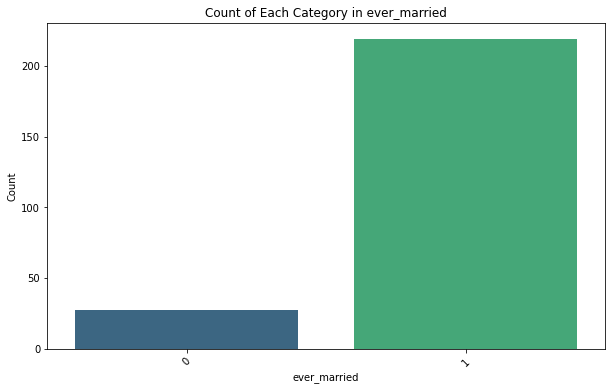

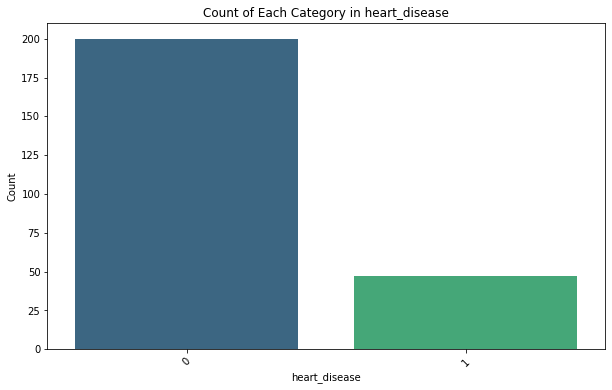

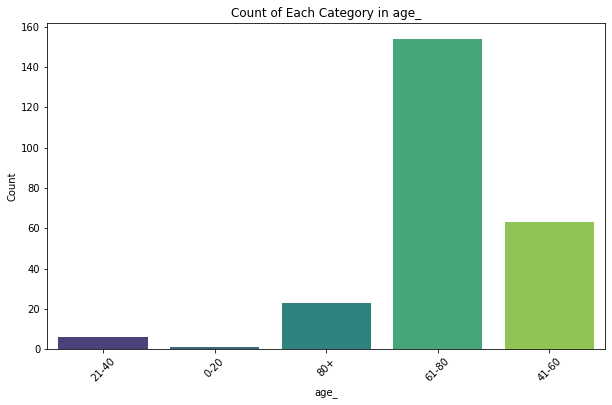

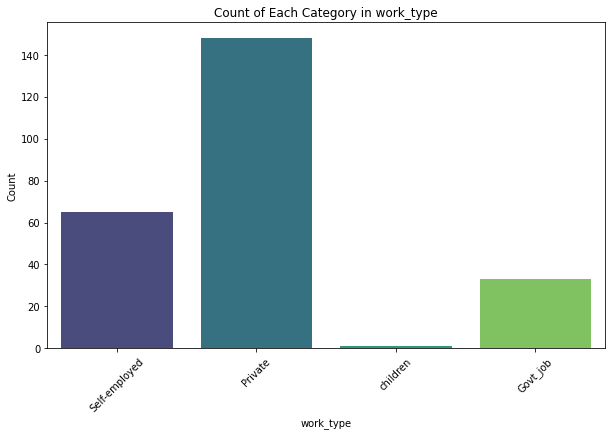

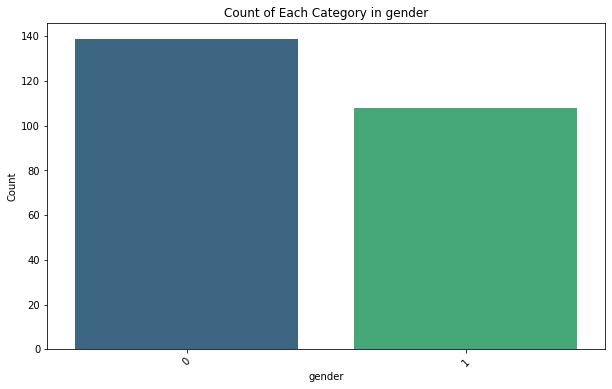

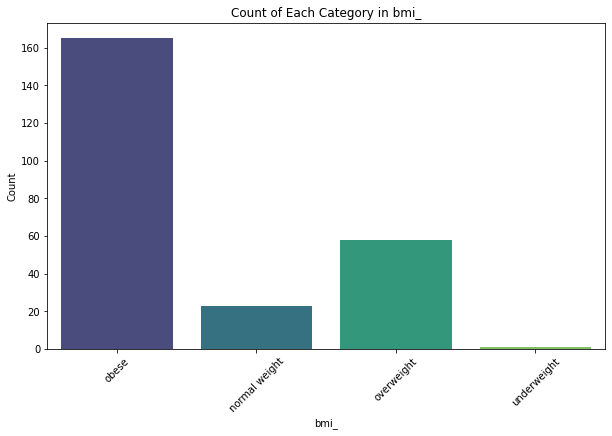

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_distribution(data, column_name):
    """
    绘制分类变量分布的条形图
    
    参数:
    data (DataFrame): PySpark DataFrame
    column_name (str): 需要绘图的列名
    """
    # 计算每个类别的计数
    cat_count = data.groupBy(column_name).agg(count("*").alias("count"))

    # 转换为 Pandas DataFrame 并绘图
    cat_count_pd = cat_count.toPandas()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y='count', data=cat_count_pd, palette="viridis")
    plt.title(f"Count of Each Category in {column_name}")
    plt.ylabel("Count")
    plt.xlabel(column_name)
    plt.xticks(rotation=45)
    plt.show()

# 你提到的变量列表
variables = [
    "smoking_status", "Residence_type", "hypertension", 
    "avg_glucose_level_", "ever_married", "heart_disease",
    "age_", "work_type", "gender", "bmi_"
]

# 对每个变量绘图
for var in variables:
    plot_categorical_distribution(data_zf, var)

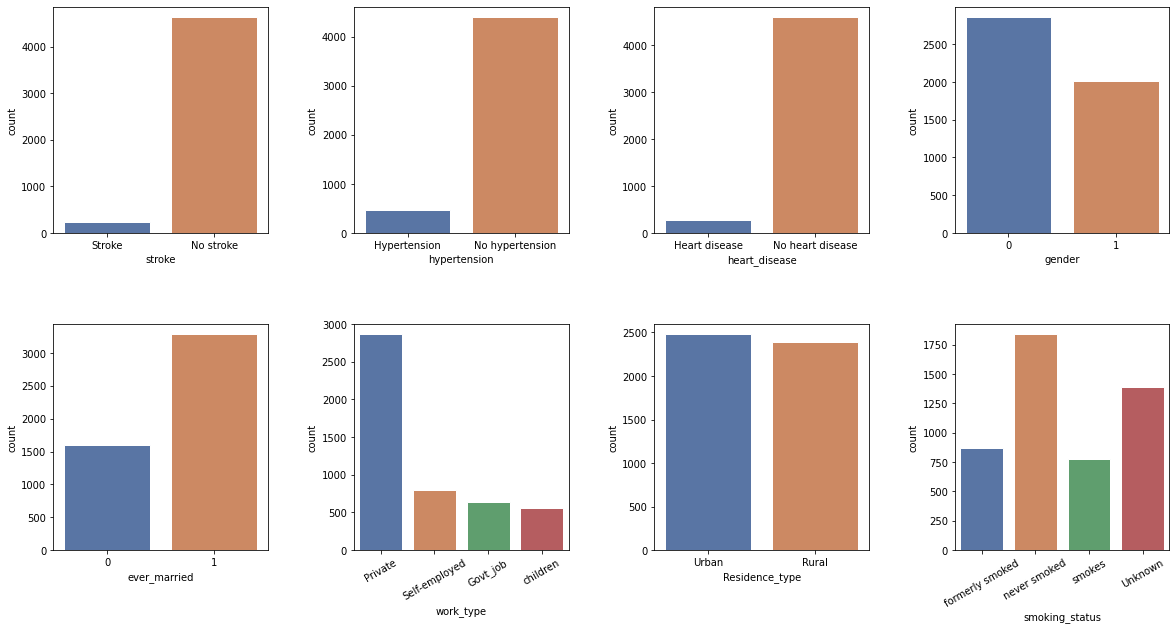

In [17]:
df_pd = data.toPandas()

df_pd.loc[(df_pd.stroke == 1), 'stroke']='Stroke'
df_pd.loc[(df_pd.stroke == 0), 'stroke']='No stroke'

df_pd.loc[(df_pd.heart_disease == 1), 'heart_disease']='Heart disease'
df_pd.loc[(df_pd.heart_disease == 0), 'heart_disease']='No heart disease'

df_pd.loc[(df_pd.hypertension == 1), 'hypertension']='Hypertension'
df_pd.loc[(df_pd.hypertension == 0), 'hypertension']='No hypertension'
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.set_theme()

sns.countplot(data=df_pd, x='stroke', ax=axes[0,0])

sns.countplot(data=df_pd, x='hypertension', order=['Hypertension', 'No hypertension'], ax=axes[0,1])

sns.countplot(data=df_pd, x='heart_disease', ax=axes[0,2])

sns.countplot(data=df_pd, x='gender', ax=axes[0,3])

sns.countplot(data=df_pd, x='ever_married', ax=axes[1,0])

sns.countplot(data=df_pd, x='work_type', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=30)

sns.countplot(data=df_pd, x='Residence_type', ax=axes[1,2])

sns.countplot(data=df_pd, x='smoking_status', ax=axes[1,3])
axes[1,3].tick_params(axis='x', rotation=30)

## Distribution Plot

<AxesSubplot:title={'center':'BMI distribution'}, xlabel='bmi', ylabel='Count'>

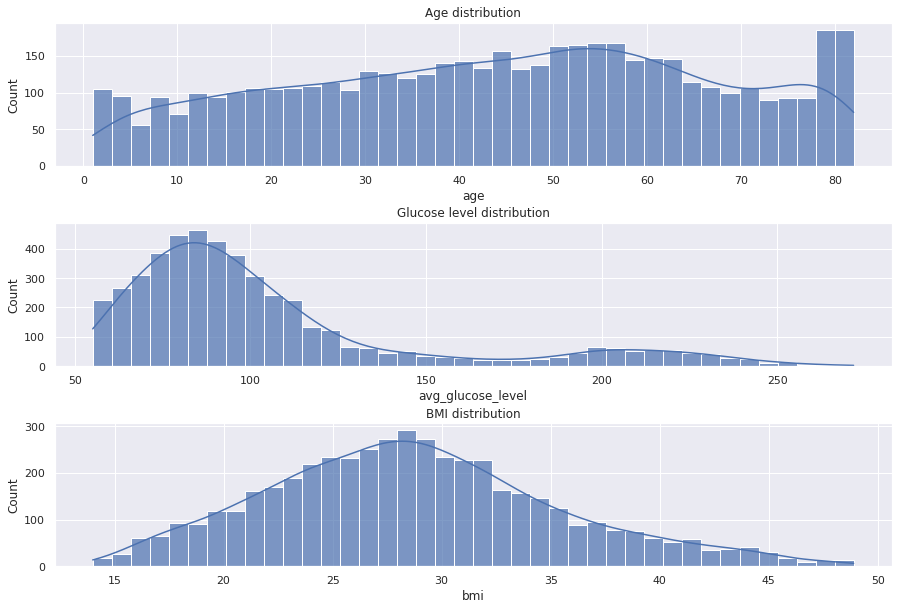

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(15,10))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()

axes[0].set_title('Age distribution')
sns.histplot(df_pd['age'], bins=40, kde=True, alpha=0.7, ax=axes[0])

axes[1].set_title('Glucose level distribution')
sns.histplot(df_pd['avg_glucose_level'], bins=40, kde=True, alpha=0.7, ax=axes[1])

axes[2].set_title('BMI distribution')
sns.histplot(df_pd['bmi'], bins=40, kde=True, alpha=0.7, ax=axes[2])

## Box Plot

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

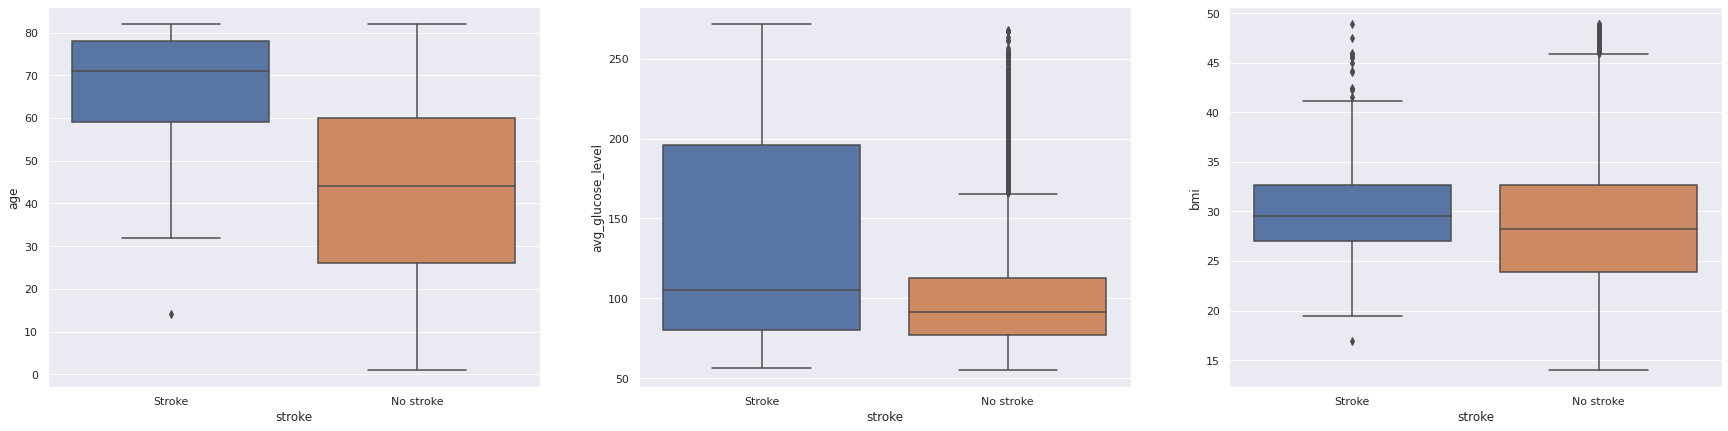

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(30,7))

sns.boxplot(data=df_pd, x='stroke', y='age', ax=axes[0])

sns.boxplot(data=df_pd, x='stroke', y='avg_glucose_level', ax=axes[1])

sns.boxplot(data=df_pd, x='stroke', y='bmi', ax=axes[2])

## Correalation Analysis

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 计算相关性
numeric_cols = ["gender", "age", "hypertension", "heart_disease", "ever_married", "avg_glucose_level", "bmi", "stroke"]

correlation_matrix = {}

for col1 in numeric_cols:
    correlation_matrix[col1] = []
    for col2 in numeric_cols:
        correlation = data.stat.corr(col1, col2)
        correlation_matrix[col1].append(correlation)
        

                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.019206      0.023227       0.088643   
age               -0.019206  1.000000      0.275778       0.265477   
hypertension       0.023227  0.275778      1.000000       0.110413   
heart_disease      0.088643  0.265477      0.110413       1.000000   
ever_married      -0.023621  0.659169      0.158031       0.109718   
avg_glucose_level  0.055959  0.236821      0.169254       0.166441   
bmi               -0.007474  0.335036      0.152265       0.054553   
stroke             0.010811  0.249175      0.131085       0.134022   

                   ever_married  avg_glucose_level       bmi    stroke  
gender                -0.023621           0.055959 -0.007474  0.010811  
age                    0.659169           0.236821  0.335036  0.249175  
hypertension           0.158031           0.169254  0.152265  0.131085  
heart_disease          0.109718           0.166441  0.054553  0.134022  
ever

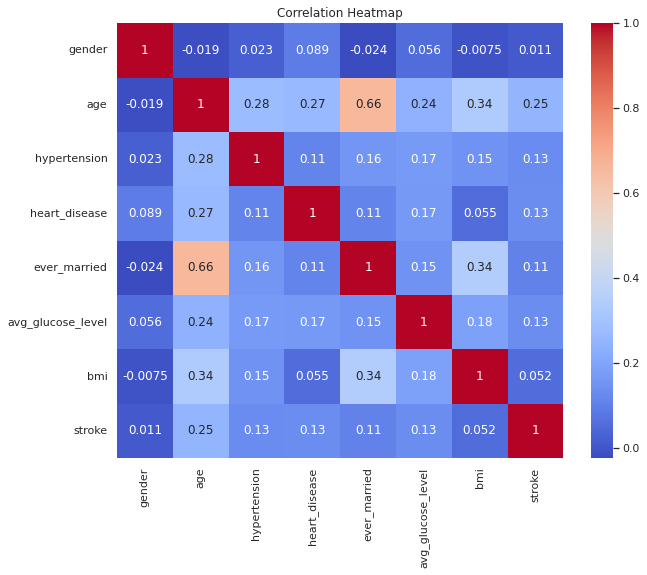

In [21]:
        
# 将相关性矩阵转换成Pandas DataFrame
corr_df = pd.DataFrame(correlation_matrix, index=numeric_cols)

print(corr_df)

# 使用seaborn绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


It can be observed that among stroke patients:

Previous smokers and the proportion of smokers are 28.34% and 17%, respectively. The majority of patients are obese, accounting for a high percentage of 66.8%, followed by overweight at 23.48%. Most of them are elderly patients, with a high percentage of 63.16% in the age range from 66 to 82 years. The differences in residential type and gender are generally consistent. Among stroke patients, 55.06% have diabetes, and 10.93% have low blood sugar. Patients with heart disease and high blood pressure are relatively few, at 19.03% and 26.72%, respectively. Among patients, the most common job type is private enterprise, followed by self-employed individuals. 88.66% of patients have been married, but based on age groups, it can be seen that most patients are in the marriageable age range, so having been married may not be a significant factor affecting stroke.

## 

# Feature Engineering

In [22]:
data.toPandas().head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_,avg_glucose_level_,age_
0,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1,obese,diabetes,61-80
1,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1,obese,diabetes,61-80
2,0,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1,obese,diabetes,41-60


In [23]:
from pyspark.sql import functions as F
from scipy.stats import chi2_contingency
import pandas as pd

def compute_chi_square(data, feature, target):
    # 创建交叉表，其中包含指定特征和目标变量的数量
    contingency_table = (
        data.crosstab(feature, target)
        .toPandas()
        .set_index(f"{feature}_{target}")
    )

    # 使用scipy计算卡方统计量和p值
    chi2_val, p_val = chi2_contingency(contingency_table)[:2]

    return (feature, chi2_val, p_val)


# 您要分析的列
columns_to_analyze = [
    "gender", "age", "hypertension",
    "heart_disease", "ever_married", "work_type",
    "Residence_type", "avg_glucose_level", "bmi"
]

# 您的目标变量列
target_column = "stroke"

# 计算每个特征的卡方值和p值
chi2_results = [compute_chi_square(data, feature, target_column) for feature in columns_to_analyze]

# 将结果转化为 DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=["feature", "chi2", "p_value"])

# 显示结果
print(chi2_df)

# 如果要找到p值大于0.05的特征
features_with_p_gt_05 = chi2_df.loc[chi2_df["p_value"] > 0.05, "feature"].tolist()
print('Fields with p-values greater than 0.05 are:', features_with_p_gt_05)

             feature         chi2       p_value
0             gender     0.473760  4.912624e-01
1                age   467.941928  8.713656e-56
2       hypertension    81.722617  1.565912e-19
3      heart_disease    84.883584  3.164596e-20
4       ever_married    52.846994  3.605700e-13
5          work_type    43.303860  2.121253e-09
6     Residence_type     1.070740  3.007783e-01
7  avg_glucose_level  4016.634811  1.616281e-02
8                bmi   366.550567  1.634599e-01
Fields with p-values greater than 0.05 are: ['gender', 'Residence_type', 'bmi']


In [24]:
df = data
df = df.drop('residence_type, ever_married')
categorical_to_drop = ('gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status', 'bmi_', 'avg_glucose_level_', 'age_')

indexer = StringIndexer(inputCol='gender', outputCol='gender_vec')
df_indexed = indexer.fit(data).transform(data)

indexer2 = StringIndexer(inputCol='avg_glucose_level_', outputCol='avg_glucose_level_cat_vec')
df_indexed2 = indexer2.fit(df_indexed).transform(df_indexed)

indexer3 = StringIndexer(inputCol='work_type', outputCol='work_vec')
df_indexed3 = indexer3.fit(df_indexed2).transform(df_indexed2)

indexer4 = StringIndexer(inputCol='age_', outputCol='age_cat_vec')
df_indexed4 = indexer4.fit(df_indexed3).transform(df_indexed3)

indexer5 = StringIndexer(inputCol='smoking_status', outputCol='smoking_vec')
df_indexed5 = indexer5.fit(df_indexed4).transform(df_indexed4)

indexer6 = StringIndexer(inputCol='bmi_', outputCol='bmi_cat_vec')
df_indexed6 = indexer6.fit(df_indexed5).transform(df_indexed5)

df = df_indexed6.drop(*categorical_to_drop)
df = df.drop(*('bmi_cat_vec','age_cat_vec','avg_glucose_level_cat_vec'))
df.toPandas().head(3)
# df.printSchema()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_vec,work_vec,smoking_vec
0,67.0,0,1,228.69,36.6,1,1.0,0.0,2.0
1,80.0,0,1,105.92,32.5,1,1.0,0.0,0.0
2,49.0,0,0,171.23,34.4,1,0.0,0.0,3.0


In [25]:
feature = VectorAssembler(inputCols = df.drop('stroke').columns, outputCol='features')
feature_vector = feature.transform(df)
feature_vector.toPandas().head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_vec,work_vec,smoking_vec,features
0,67.0,0,1,228.69,36.6,1,1.0,0.0,2.0,"[67.0, 0.0, 1.0, 228.69, 36.6, 1.0, 0.0, 2.0]"
1,80.0,0,1,105.92,32.5,1,1.0,0.0,0.0,"[80.0, 0.0, 1.0, 105.92, 32.5, 1.0, 0.0, 0.0]"
2,49.0,0,0,171.23,34.4,1,0.0,0.0,3.0,"(49.0, 0.0, 0.0, 171.23, 34.4, 0.0, 0.0, 3.0)"


# Splitting the Training Set

In [26]:
ml_df = feature_vector.select(['features', 'stroke'])
train, test = ml_df.randomSplit([0.8, 0.2])

ml_df.toPandas().head(3)

,features,stroke
0,"[67.0, 0.0, 1.0, 228.69, 36.6, 1.0, 0.0, 2.0]",1
1,"[80.0, 0.0, 1.0, 105.92, 32.5, 1.0, 0.0, 0.0]",1
2,"(49.0, 0.0, 0.0, 171.23, 34.4, 0.0, 0.0, 3.0)",1


# Model Prediction

## Logistic Regression

In [27]:
# 初始化逻辑回归模型
lr = LogisticRegression(featuresCol='features', labelCol='stroke')

# 使用训练数据拟合模型
lr_model = lr.fit(train)

# 使用模型在测试集上进行预测
lr_predictions = lr_model.transform(test)


# 输出预测结果
lr_predictions.select("prediction", "stroke", "features").show(5)

# 计算模型的accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Test Accuracy = %g" % lr_accuracy)

# 计算模型的Precision
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
lr_precision = evaluator.evaluate(lr_predictions)
print("Test Precision = %g" % lr_precision)

# 计算模型的AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
print("Test AUC = %g" % lr_auc)


lr_predictions.toPandas()

+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(8,[0,1,3,4],[36....|
|       0.0|     0|(8,[0,1,3,4],[40....|
|       0.0|     0|(8,[0,1,3,4],[44....|
|       0.0|     0|(8,[0,1,3,4],[51....|
|       0.0|     0|(8,[0,1,3,4],[52....|
+----------+------+--------------------+
only showing top 5 rows

Test Accuracy = 0.958374
Test Precision = 0.91848
Test AUC = 0.831008


,features,stroke,rawPrediction,probability,prediction
0,"(36.0, 1.0, 0.0, 91.56, 42.2, 0.0, 0.0, 0.0)",0,"[4.2758440735394725, -4.2758440735394725]","[0.9862902587837766, 0.01370974121622337]",0.0
1,"(40.0, 1.0, 0.0, 81.59, 27.2, 0.0, 0.0, 0.0)",0,"[4.2432416621524744, -4.2432416621524744]","[0.9858423545055562, 0.01415764549444376]",0.0
2,"(44.0, 1.0, 0.0, 69.48, 41.3, 0.0, 0.0, 0.0)",0,"[3.8225603128606354, -3.8225603128606354]","[0.9785964030353324, 0.02140359696466765]",0.0
3,"(51.0, 1.0, 0.0, 85.84, 31.8, 0.0, 0.0, 0.0)",0,"[3.3690593102078834, -3.3690593102078834]","[0.9667234431788786, 0.033276556821121406]",0.0
4,"(52.0, 1.0, 0.0, 81.03, 32.6, 0.0, 0.0, 0.0)",0,"[3.31002372537643, -3.31002372537643]","[0.9647710871771858, 0.03522891282281415]",0.0
...,...,...,...,...,...
1028,"[82.0, 0.0, 1.0, 88.6, 32.5, 0.0, 1.0, 1.0]",0,"[1.1340905778645487, -1.1340905778645487]","[0.7565930104987456, 0.2434069895012544]",0.0
1029,"[82.0, 1.0, 0.0, 115.71, 31.1, 0.0, 0.0, 2.0]",0,"[0.8340393557657304, -0.8340393557657304]","[0.6972083523094437, 0.30279164769055633]",0.0
1030,"[82.0, 1.0, 0.0, 222.52, 31.8, 0.0, 0.0, 2.0]",0,"[0.29688791555718197, -0.29688791555718197]","[0.5736815662265973, 0.4263184337734027]",0.0
1031,"[82.0, 1.0, 1.0, 101.56, 31.5, 0.0, 1.0, 0.0]",0,"[0.8404556905968796, -0.8404556905968796]","[0.6985611810285144, 0.3014388189714856]",0.0


## Decision Tree

In [29]:
# 初始化决策树模型
dt = DecisionTreeClassifier(featuresCol='features', labelCol='stroke')

# 使用训练数据拟合模型
dt_model = dt.fit(train)

# 使用模型在测试集上进行预测
dt_predictions = dt_model.transform(test)

# 输出预测结果
dt_predictions.select("prediction", "stroke", "features").show(5)

# 计算模型的accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
print("Test Accuracy = %g" % dt_accuracy)

# 计算模型的Precision
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
dt_precision = evaluator.evaluate(dt_predictions)
print("Test Precision = %g" % dt_precision)

# 计算模型的AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
dt_auc = evaluator.evaluate(dt_predictions)
print("Test AUC = %g" % dt_auc)


+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(8,[0,1,3,4],[36....|
|       0.0|     0|(8,[0,1,3,4],[40....|
|       0.0|     0|(8,[0,1,3,4],[44....|
|       0.0|     0|(8,[0,1,3,4],[51....|
|       0.0|     0|(8,[0,1,3,4],[52....|
+----------+------+--------------------+
only showing top 5 rows

Test Accuracy = 0.959342
Test Precision = 0.947976
Test AUC = 0.453488


## Random Forest

In [30]:
# 初始化随机森林分类器
rf = RandomForestClassifier(featuresCol='features', labelCol='stroke')

# 使用训练数据拟合模型
rf_model = rf.fit(train)

# 使用模型在测试集上进行预测
rf_predictions = rf_model.transform(test)

# 输出预测结果
rf_predictions.select("prediction", "stroke", "features").show(5)

# 计算模型的accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print("Test Accuracy = %g" % rf_accuracy)

# 计算模型的Precision
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = evaluator.evaluate(rf_predictions)
print("Test Precision = %g" % rf_precision)

# 计算模型的AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print("Test AUC = %g" % rf_auc)


+----------+------+--------------------+
|prediction|stroke|            features|
+----------+------+--------------------+
|       0.0|     0|(8,[0,1,3,4],[36....|
|       0.0|     0|(8,[0,1,3,4],[40....|
|       0.0|     0|(8,[0,1,3,4],[44....|
|       0.0|     0|(8,[0,1,3,4],[51....|
|       0.0|     0|(8,[0,1,3,4],[52....|
+----------+------+--------------------+
only showing top 5 rows

Test Accuracy = 0.958374
Test Precision = 0.91848
Test AUC = 0.813789


# Model Comparison

## Model Performance

In [31]:
import pandas as pd

data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision],
    'AUC': [lr_auc, dt_auc, rf_auc]
}

results_df = pd.DataFrame(data)
print(results_df)

                 Model  Accuracy  Precision       AUC
0  Logistic Regression  0.958374   0.918480  0.831008
1        Decision Tree  0.959342   0.947976  0.453488
2        Random Forest  0.958374   0.918480  0.813789


In [32]:
# 对于逻辑回归，我们查看系数的绝对值
import builtins
lr_importances = [builtins.abs(coef) for coef in lr_model.coefficients]


# 对于决策树和随机森林，我们可以直接获取featureImportances
dt_importances = dt_model.featureImportances
rf_importances = rf_model.featureImportances

# 你的特征名称列表
feature_names = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_vec', 'work_vec', 'smoking_vec']


## Model Result

In [33]:
import pandas as pd

# 将上述特征重要性列表合并为一个DataFrame
lr_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': lr_importances
})
lr_importances_df = lr_importances_df.sort_values(by='Logistic Regression', ascending=False)


lr_importances_df.head(8)

,Feature,Logistic Regression
2,heart_disease,0.347229
1,hypertension,0.328432
6,work_vec,0.119015
5,gender_vec,0.109171
7,smoking_vec,0.085110
0,age,0.071834
4,bmi,0.013699
3,avg_glucose_level,0.004939


In [34]:
import pandas as pd
import numpy as np

# 将上述特征重要性列表合并为一个DataFrame
dt_importances_np = np.array(dt_importances)

# 将上述特征重要性列表合并为一个DataFrame
ds_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Decision Tree': dt_importances_np
})

# 排序 DataFrame
ds_importances_df = ds_importances_df.sort_values(by='Decision Tree', ascending=False)

# 打印前8行
ds_importances_df.head(8)

,Feature,Decision Tree
0,age,0.691027
3,avg_glucose_level,0.122625
7,smoking_vec,0.087403
2,heart_disease,0.041245
6,work_vec,0.030998
4,bmi,0.026702
1,hypertension,0.000000
5,gender_vec,0.000000


In [35]:
# 首先将其转换为 NumPy 数组
rf_importances_np = np.array(rf_importances)

# 将上述特征重要性列表合并为一个DataFrame
rf_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_importances_np
})

# 排序 DataFrame
rf_importances_df = rf_importances_df.sort_values(by='Random Forest', ascending=False)

# 打印前8行
rf_importances_df.head(8)

,Feature,Random Forest
0,age,0.396811
3,avg_glucose_level,0.228732
4,bmi,0.113386
2,heart_disease,0.095253
1,hypertension,0.054210
7,smoking_vec,0.046059
6,work_vec,0.043035
5,gender_vec,0.022513
